In [1]:
%load_ext autotime
import pandas as pd
from mikeio.eum import EUMType, ItemInfo
from fmskill.model import ModelResult
from fmskill.observation import TrackObservation
import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png')

time: 3.5 s (started: 2021-03-24 07:52:33 +01:00)


# Extract track without having observation as dfs0

In [2]:
fn = '../tests/testdata/NorthSeaHD_and_windspeed.dfsu'
mr = ModelResult(fn, name='HD')
mr.dfs

Dfsu2D
Number of elements: 958
Number of nodes: 570
Projection: LONG/LAT
Items:
  0:  Surface elevation <Surface Elevation> (meter)
  1:  Wind speed <Wind speed> (meter per sec)
Time: 67 steps with dt=3600.0s
      2017-10-27 00:00:00 -- 2017-10-29 18:00:00

time: 390 ms (started: 2021-03-23 21:48:33 +01:00)


In [3]:
fn = '../tests/testdata/altimetry_NorthSea_20171027.csv'
df = pd.read_csv(fn, index_col=0, parse_dates=True)

time: 31 ms (started: 2021-03-23 21:48:34 +01:00)


In [4]:
o1 = TrackObservation(df, item=2, name='alti')
o1.itemInfo = ItemInfo(EUMType.Surface_Elevation)    # if TrackObservation is created with a df, itemInfo needs to be added manually

time: 16 ms (started: 2021-03-23 21:48:34 +01:00)


In [5]:
mr.add_observation(o1, item=0)

time: 0 ns (started: 2021-03-23 21:48:34 +01:00)


In [6]:
cc = mr.extract()

time: 94 ms (started: 2021-03-23 21:48:34 +01:00)


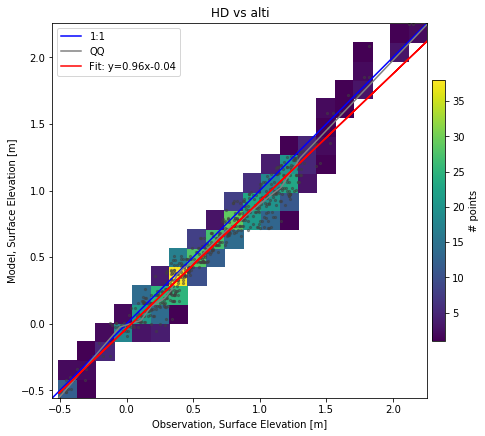

time: 547 ms (started: 2021-03-23 21:48:34 +01:00)


In [7]:
cc['alti'].scatter()

# Extract track from dfs0
ModelResult is now a dfs0

In [8]:
fn = '../tests/testdata/NorthSeaHD_extracted_track.dfs0'
mr = ModelResult(fn, name='HD')
mr.dfs

<mikeio.Dfs0>
Timeaxis: TimeAxisType.NonEquidistantCalendar
Items:
  0:  Longitude <Undefined> (undefined)
  1:  Latitude <Undefined> (undefined)
  2:  Model_surface_elevation <Undefined> (undefined)
  3:  Model_wind_speed <Undefined> (undefined)

time: 16 ms (started: 2021-03-23 21:48:34 +01:00)


In [9]:
fn = '../tests/testdata/altimetry_NorthSea_20171027.csv'
df = pd.read_csv(fn, index_col=0, parse_dates=True)
o1 = TrackObservation(df, item=2, name='alti')

time: 15 ms (started: 2021-03-23 21:48:34 +01:00)


In [10]:
mr.add_observation(o1, item=2)

time: 0 ns (started: 2021-03-23 21:48:35 +01:00)


In [11]:
cc = mr.extract()

time: 32 ms (started: 2021-03-23 21:48:35 +01:00)


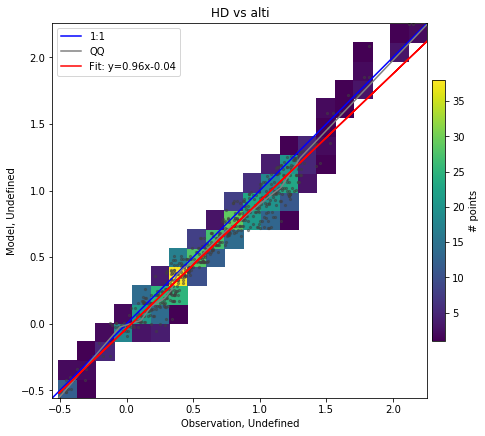

time: 516 ms (started: 2021-03-23 21:48:35 +01:00)


In [12]:
cc['alti'].scatter()

# Big data
Run the download.ipynb first

In [2]:
fn = '../data/SW_gwm_3a_extracted_2018.dfs0'
mr = ModelResult(fn, name='GWM')

time: 422 ms (started: 2021-03-24 07:53:08 +01:00)


In [3]:
fn = '../data/altimetry_3a_2018_filter1.dfs0'
o1 = TrackObservation(fn, item=2, name='3a')

time: 2min 33s (started: 2021-03-24 07:53:14 +01:00)


In [4]:
mr.add_observation(o1, item=2)

time: 0 ns (started: 2021-03-24 07:55:52 +01:00)


In [5]:
cc = mr.extract()

time: 2min 16s (started: 2021-03-24 07:55:55 +01:00)


In [17]:
cc['3a'].skill_df(end='2018-1-15')

,n,bias,rmse,urmse,mae,cc,si,r2
observation,,,,,,,,
3a,372356,-0.475229,0.633093,0.418287,0.510757,0.940399,0.116879,0.968706


time: 1min 5s (started: 2021-03-23 21:53:35 +01:00)


In [18]:
cc['3a'].skill_df()

,n,bias,rmse,urmse,mae,cc,si,r2
observation,,,,,,,,
3a,9105364,-0.489382,0.645991,0.421675,0.520273,0.94304,0.11582,0.968518


time: 4.83 s (started: 2021-03-23 21:54:41 +01:00)


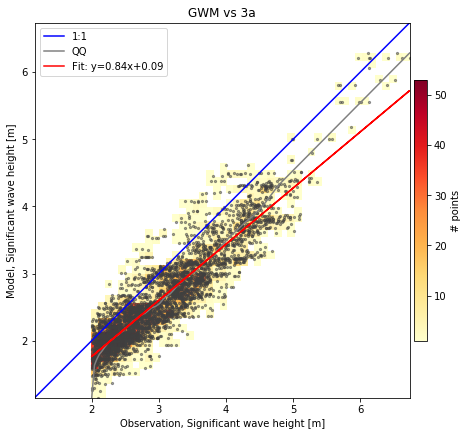

time: 4.22 s (started: 2021-03-23 21:54:45 +01:00)


In [19]:
cc['3a'].scatter(end='2018-7-1', area=[0,50,10,60], binsize=0.1, cmap='YlOrRd')

# Spatial binning

In [6]:
import xarray as xr
import numpy as np

time: 2.06 s (started: 2021-03-24 07:58:35 +01:00)


In [22]:
df = cc.all_df

time: 0 ns (started: 2021-03-24 08:24:27 +01:00)


In [9]:
df['lonBin'] = pd.cut(df.x,bins=360)
df['latBin'] = pd.cut(df.y,bins=180)

time: 1.56 s (started: 2021-03-24 08:09:04 +01:00)


Find lon and lat bin centers, To-Do: better way?

In [10]:
lonBin = df['lonBin'].unique()
lon = [lon.mid for lon in lonBin]
df = df.join(pd.DataFrame(index=lonBin,data=dict(lon=lon)),on='lonBin')
latBin = df['latBin'].unique()
lat = [lat.mid for lat in latBin]
df = df.join(pd.DataFrame(index=latBin,data=dict(lat=lat)),on='latBin')
df.head()

,mod_name,obs_name,x,y,mod_val,obs_val,lonBin,latBin,lon,lat
2018-01-01 00:00:00.000000,GWM,3a,-33.706020,23.181158,2.292599,2.611,"(-34.0, -33.0]","(22.689, 23.573]",-33.5,23.131
2018-01-01 00:00:01.000005,GWM,3a,-33.720741,23.240074,2.292612,2.608,"(-34.0, -33.0]","(22.689, 23.573]",-33.5,23.131
2018-01-01 00:00:01.999999,GWM,3a,-33.735474,23.298990,2.292624,2.518,"(-34.0, -33.0]","(22.689, 23.573]",-33.5,23.131
2018-01-01 00:00:03.000004,GWM,3a,-33.750214,23.357904,2.292637,2.729,"(-34.0, -33.0]","(22.689, 23.573]",-33.5,23.131
2018-01-01 00:00:03.999998,GWM,3a,-33.764965,23.416819,2.292650,2.593,"(-34.0, -33.0]","(22.689, 23.573]",-33.5,23.131


time: 4.16 s (started: 2021-03-24 08:09:08 +01:00)


In [26]:
QIs = []
min_observations = 30
for (lon,lat),dfi in df.groupby(['lon','lat']):
    n = len(dfi)
    if n < min_observations:
        continue

    QIi = pd.DataFrame(index=[1],data=dict(N_obs=dfi['obs_val'].count(),mean_obs=dfi['obs_val'].mean(),
        N_mdl=dfi['mod_val'].count(),mean_mdl=dfi['mod_val'].mean()))
    resi =  dfi['obs_val'] - dfi['mod_val']
    
    QIi['n'] = n
    QIi['bias'] = QIi['mean_mdl']-QIi['mean_obs'] 
    QIi['rmse'] = np.sqrt(np.mean(resi**2))
    
    QIi['lon'] = lon
    QIi['lat'] = lat
    QIs.append(QIi.set_index(['lon','lat']))

QI = pd.concat(QIs)
QI.head()

N_obs  mean_obs  N_mdl  mean_mdl   n      bias      rmse
lon     lat                                                               
-179.68 -76.7035     30  2.889900     30  2.255722  30 -0.634178  0.696457
        -75.8200     46  3.084913     46  2.405674  46 -0.679239  0.827850
        -74.0530     45  2.970933     45  2.504309  45 -0.466624  0.699758
        -73.1695     46  2.934717     46  2.772933  46 -0.161785  0.419096
        -72.2860     75  2.867347     75  2.590579  75 -0.276767  0.411649

time: 8min 13s (started: 2021-03-23 22:03:07 +01:00)


In [27]:
ds = QI.to_xarray()

time: 16 ms (started: 2021-03-23 22:11:55 +01:00)


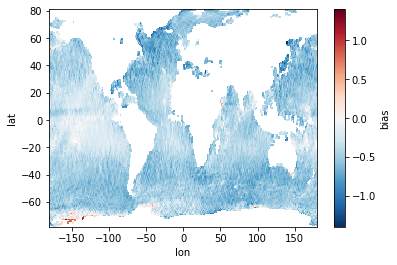

time: 547 ms (started: 2021-03-23 22:11:57 +01:00)


In [28]:
ds['bias'].plot(x='lon',y='lat')

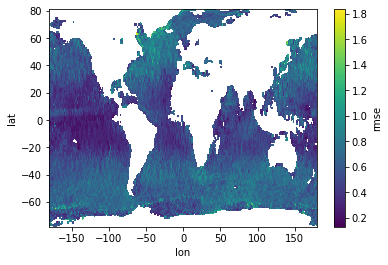

time: 609 ms (started: 2021-03-23 22:12:00 +01:00)


In [29]:
ds['rmse'].plot(x='lon',y='lat')

## pandas split - apply - combine

https://pandas.pydata.org/docs/user_guide/groupby.html#flexible-apply 


In [12]:
from fmskill import metrics
def compute_metrics(x):
   result = dict(N_obs=x['obs_val'].count(),
                 mean_obs=x['obs_val'].mean(),
                 N_mdl=x['mod_val'].count(),
                 mean_mdl=x['mod_val'].mean(),
                 n=len(x),
                 bias=metrics.bias(x['obs_val'],x['mod_val']),
                 rmse=metrics.rmse(x['obs_val'],x['mod_val']))
   return pd.Series(result, name="metrics")

time: 0 ns (started: 2021-03-24 08:11:19 +01:00)


In [31]:
QI = df.groupby(['lon','lat']).apply(compute_metrics)
QI = QI[QI.n>=30]
QI.head()

metrics           N_obs  mean_obs  N_mdl  mean_mdl     n      bias      rmse
lon     lat                                                                 
-179.68 -76.7035   30.0  2.889900   30.0  2.255722  30.0 -0.634178  0.696457
        -75.8200   46.0  3.084913   46.0  2.405674  46.0 -0.679239  0.827850
        -74.0530   45.0  2.970933   45.0  2.504309  45.0 -0.466624  0.699758
        -73.1695   46.0  2.934717   46.0  2.772933  46.0 -0.161785  0.419096
        -72.2860   75.0  2.867347   75.0  2.590579  75.0 -0.276767  0.411649

time: 2min 20s (started: 2021-03-23 22:12:06 +01:00)


--> Allmost 4 times faster than groupby + append + concat version

In [32]:
ds = QI.to_xarray()

time: 31 ms (started: 2021-03-23 22:17:00 +01:00)


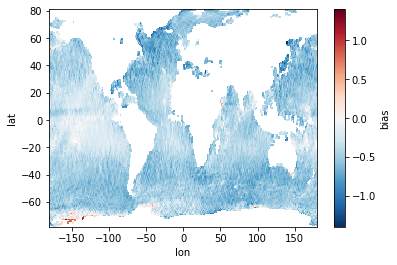

time: 547 ms (started: 2021-03-23 22:17:02 +01:00)


In [33]:
ds['bias'].plot(x='lon',y='lat')

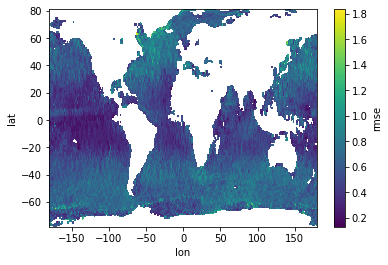

time: 547 ms (started: 2021-03-23 22:17:05 +01:00)


In [34]:
ds['rmse'].plot(x='lon',y='lat')

Performance difference if preselecting only required columns of df?

In [35]:
QI = df[['lon','lat','obs_val','mod_val']].groupby(['lon','lat']).apply(compute_metrics)
QI = QI[QI.n>=30]
QI.head()

metrics           N_obs  mean_obs  N_mdl  mean_mdl     n      bias      rmse
lon     lat                                                                 
-179.68 -76.7035   30.0  2.889900   30.0  2.255722  30.0 -0.634178  0.696457
        -75.8200   46.0  3.084913   46.0  2.405674  46.0 -0.679239  0.827850
        -74.0530   45.0  2.970933   45.0  2.504309  45.0 -0.466624  0.699758
        -73.1695   46.0  2.934717   46.0  2.772933  46.0 -0.161785  0.419096
        -72.2860   75.0  2.867347   75.0  2.590579  75.0 -0.276767  0.411649

time: 1min 52s (started: 2021-03-23 22:17:11 +01:00)


--> some improvement, keep in mind if number of columns increases

# Multi binning

## Spatial and monthly

Coarser spatial binning, else too little data per month.

To-Do: 'Auto-binning' utility based on min number of observations requested by user?

In [85]:
df = cc.all_df

time: 16 ms (started: 2021-03-24 08:56:13 +01:00)


In [86]:
df['lonBin'] = pd.cut(df.x,bins=90)
df['latBin'] = pd.cut(df.y,bins=45)
lonBin = df['lonBin'].unique()
lon = [lon.mid for lon in lonBin]
df = df.join(pd.DataFrame(index=lonBin,data=dict(lon=lon)),on='lonBin')
latBin = df['latBin'].unique()
lat = [lat.mid for lat in latBin]
df = df.join(pd.DataFrame(index=latBin,data=dict(lat=lat)),on='latBin')

time: 4.86 s (started: 2021-03-24 08:56:15 +01:00)


Technically not needed to add month column to dataframe, as groupby would accept df.index.month as input. But this way it is easier to pass it through to xarray later.

In [88]:
df['month'] = df.index.month

time: 1.34 s (started: 2021-03-24 08:56:51 +01:00)


In [89]:
QI = df.groupby(['month','lon','lat'])[['obs_val','mod_val']].apply(compute_metrics)
QI = QI[QI.n>=30]
QI.head()

metrics                N_obs  mean_obs  N_mdl  mean_mdl      n      bias  \
month lon     lat                                                          
1     -178.18 -69.194  111.0  3.059270  111.0  3.082899  111.0  0.023629   
              -65.660  443.0  3.114569  443.0  2.906647  443.0 -0.207921   
              -62.126  664.0  3.412003  664.0  3.154587  664.0 -0.257416   
              -58.592  541.0  3.447275  541.0  3.162531  541.0 -0.284744   
              -55.058  487.0  3.402123  487.0  3.040225  487.0 -0.361899   

metrics                    rmse  
month lon     lat                
1     -178.18 -69.194  0.303340  
              -65.660  0.443546  
              -62.126  0.395748  
              -58.592  0.395711  
              -55.058  0.504109

time: 1min 24s (started: 2021-03-24 08:56:55 +01:00)


In [90]:
ds = QI.to_xarray()
ds

<xarray.Dataset>
Dimensions:   (lat: 45, lon: 90, month: 12)
Coordinates:
  * month     (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
  * lon       (lon) float64 -178.2 -174.0 -170.0 -166.0 ... 170.0 174.0 178.0
  * lat       (lat) float64 -76.34 -72.73 -69.19 -65.66 ... 72.16 75.7 79.23
Data variables:
    N_obs     (month, lon, lat) float64 nan nan 111.0 443.0 ... nan nan nan nan
    mean_obs  (month, lon, lat) float64 nan nan 3.059 3.115 ... nan nan nan nan
    N_mdl     (month, lon, lat) float64 nan nan 111.0 443.0 ... nan nan nan nan
    mean_mdl  (month, lon, lat) float64 nan nan 3.083 2.907 ... nan nan nan nan
    n         (month, lon, lat) float64 nan nan 111.0 443.0 ... nan nan nan nan
    bias      (month, lon, lat) float64 nan nan 0.02363 -0.2079 ... nan nan nan
    rmse      (month, lon, lat) float64 nan nan 0.3033 0.4435 ... nan nan nan

time: 109 ms (started: 2021-03-24 08:58:38 +01:00)


### Some xarray data exploration and plotting
Check the mean number of observations per month (aggregate over dimension month, then plot)

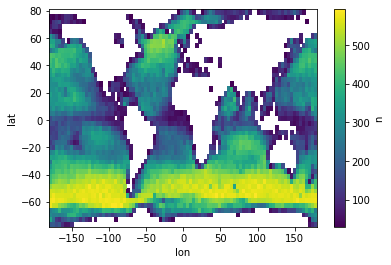

time: 406 ms (started: 2021-03-24 09:02:20 +01:00)


In [97]:
ds['n'].mean(dim='month').plot(x='lon',y='lat')

Plot bias for selected month

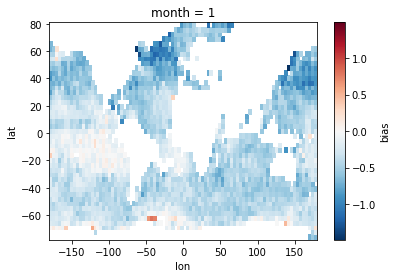

time: 407 ms (started: 2021-03-24 09:01:11 +01:00)


In [96]:
ds['bias'].sel(month=1).plot(x='lon',y='lat')

Plot rmse of all months

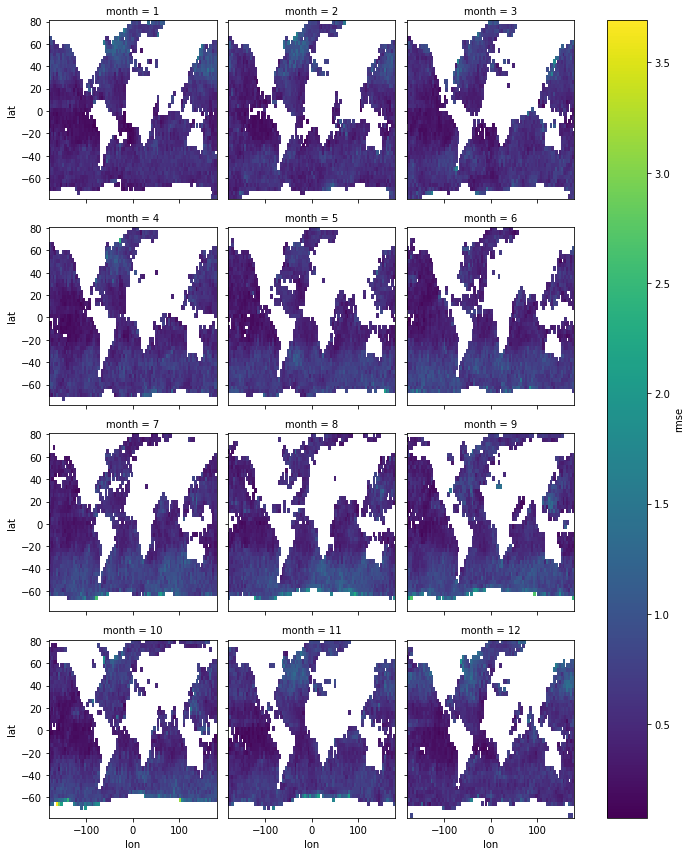

time: 4.49 s (started: 2021-03-24 09:06:31 +01:00)


In [101]:
ds['rmse'].plot(x='lon',y='lat',col='month',col_wrap=3)

Vertical cross section of bias per month

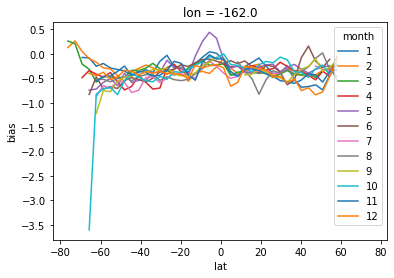

time: 484 ms (started: 2021-03-24 09:11:50 +01:00)


In [107]:
ds['bias'].sel(lon=-162).plot(x='lat',hue='month')
